In [1]:
import pandas as pd
import empyrical
from WindPy import w
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
data = w.wsd('DR001.IB', 'close', '2018-01-01', '2018-05-14')

In [4]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

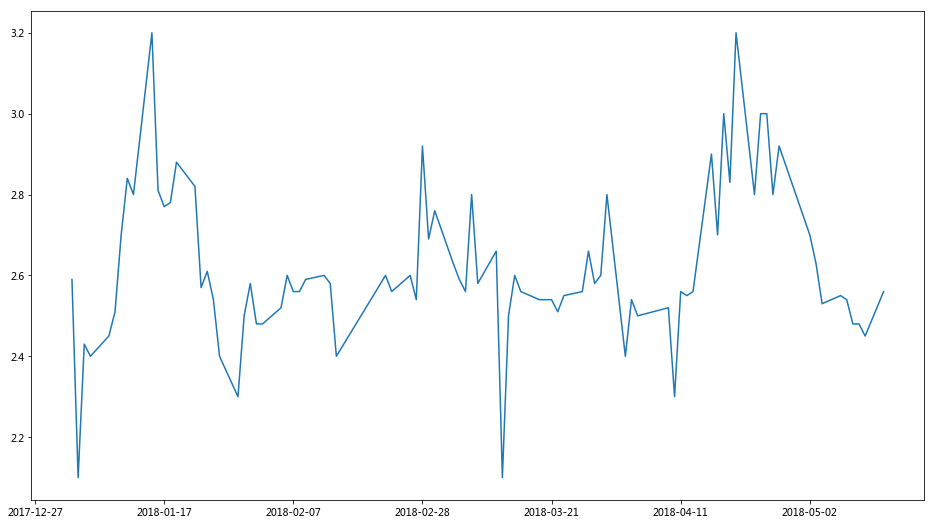

In [6]:
df['DR001.IB'].plot(figsize=(16, 9))

In [10]:
data = w.wsd('USDCNH.FX,USDCNY.IB', 'close', '2013-01-01', '2014-01-01')

In [11]:
data

.ErrorCode=0
.Codes=[USDCNH.FX,USDCNY.IB]
.Fields=[CLOSE]
.Times=[20130104,20130107,20130108,20130109,20130110,20130111,20130114,20130115,20130116,20130117,...]
.Data=[[6.2132,6.2132,6.2096,6.2096,6.2096,6.187,6.187,6.187,6.1866,6.1838,...],[6.2303,6.2296,6.2241,6.2262,6.2244,6.2161,6.2192,6.2136,6.2165,6.216,...]]

In [36]:
data = w.edb("M5525756", "2000-01-08", "2018-05-08", "Fill=Previous")

In [37]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times)
df.index = pd.to_datetime(df.index)

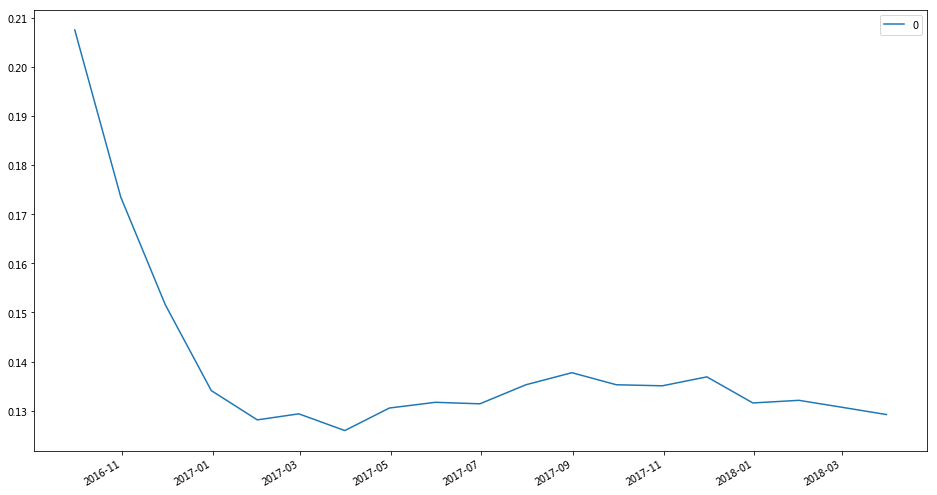

In [38]:
df[df.index >= '2004-01-01'].pct_change(12).plot(figsize=(16, 9))

In [12]:
data = w.wsd('600315.SH', 'close', '2016-04-25', '2018-04-24')

In [13]:
df = pd.DataFrame(np.array(data.Data).T, columns=['close'], index=data.Times)

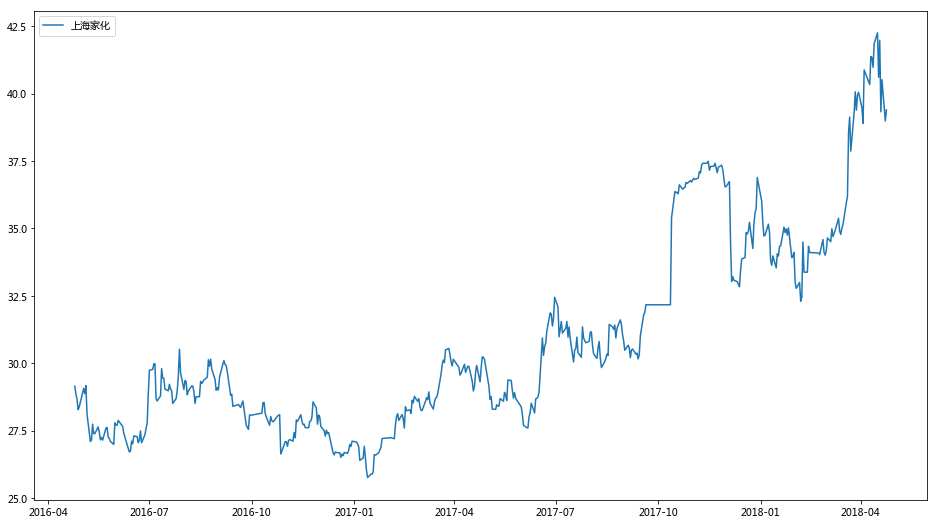

In [16]:
df['close'].plot(figsize=(16, 9), label=u'上海家化')
plt.legend()

In [54]:
df = pd.read_excel('D:/Data/assets/currency/cfets.xlsx')

In [55]:
df

,美元指数,CFETS人民币汇率指数
2013-03-28,83.0000,NaN
2013-03-29,82.9900,NaN
2013-04-01,82.7300,NaN
2013-04-02,82.8900,NaN
2013-04-03,82.7600,NaN
2013-04-08,82.7100,NaN
2013-04-09,82.3900,NaN
2013-04-10,82.4900,NaN
2013-04-11,82.2500,NaN
2013-04-12,82.1000,NaN


In [57]:
df.loc[df[u'CFETS人民币汇率指数'].shift() == df[u'CFETS人民币汇率指数'], u'CFETS人民币汇率指数'] = np.NAN

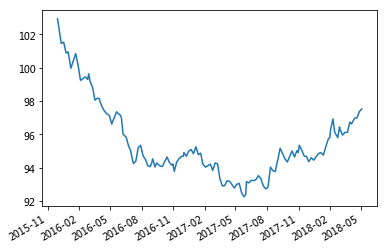

In [58]:
df[u'CFETS人民币汇率指数'].dropna().plot()

In [4]:
x = [150,
200,
250,
300,
350,
400,
600,
]

In [5]:
y = [6450,
7450,
8450,
9450,
11450,
15450,
18450,
]

In [6]:
reg = linear_model.LinearRegression()

In [8]:
reg.fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
reg.coef_

array([[ 28.77659574]])

In [2]:
df = pd.read_excel('./data/assets.xlsx')

In [38]:
vol = df.pct_change().rolling(window=243).apply(lambda x: empyrical.annual_volatility(x))

In [39]:
vol = vol[['881001.WI', 'CBA00101.CS']].dropna()

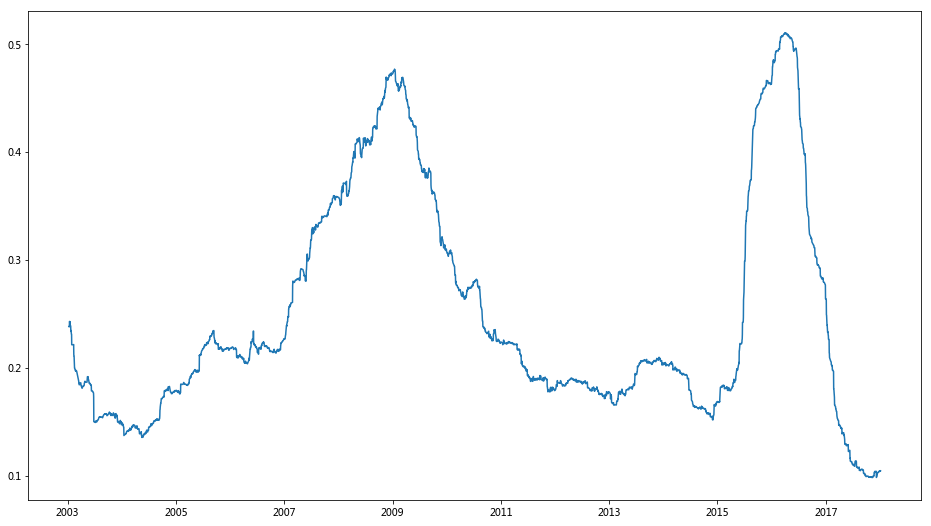

In [40]:
plt.figure(figsize=(16, 9))
plt.plot(vol['881001.WI'] - vol['CBA00101.CS'])

In [16]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [21]:
data = w.wsd('CBA00101.CS', 'close', '2018-01-01', '2018-02-28')

In [22]:
data

.ErrorCode=0
.Codes=[CBA00101.CS]
.Fields=[CLOSE]
.Times=[20180102,20180103,20180104,20180105,20180108,20180109,20180110,20180111,20180112,20180115,...]
.Data=[[None,None,None,None,None,None,None,None,None,None,...]]

In [2]:
df = pd.read_excel('D:/workspace/zjsxzy_in_js/website/word_heat/data/percentile.xlsx')

In [3]:
tdf = pd.read_excel('D:/workspace/zjsxzy_in_js/website/word_heat/data/wei_percentile.xlsx')

In [41]:
df = pd.read_excel('D:/Data/macro/us/VIXCLS.xls', skiprows=10, index_col=0)

In [45]:
df.replace([0.00], np.NAN).dropna()

,VIXCLS
observation_date,
1990-01-02,17.24
1990-01-03,18.19
1990-01-04,19.22
1990-01-05,20.11
1990-01-08,20.26
1990-01-09,22.20
1990-01-10,22.44
1990-01-11,20.05
1990-01-12,24.64


In [52]:
INDEX_DIR = 'D:/Data/index/'

In [54]:
codes = ['CI0050%02d.WI'%(i) for i in range(1, 30)]

In [55]:
dic = {}
for code in codes:
    temp = pd.read_excel('%s/%s.xlsx'%(INDEX_DIR, code), index_col=0)
    dic[code] = temp
pnl = pd.Panel(dic)

In [94]:
pnl.loc[:, :, 'return'] = pnl.minor_xs('close').pct_change()

In [95]:
df = pnl.minor_xs('return')

In [101]:
pnl.minor_xs('close')

,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2004-01-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-06,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-07,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-08,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-09,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-12,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-13,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-14,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2004-01-15,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [78]:
def roll(df, w):
    """
    This fucntion comes from:
    http://stackoverflow.com/questions/37486502/why-does-pandas-rolling-use-single-dimension-ndarray/37491779#37491779
    """
    df.fillna(df.mean(), inplace=True)
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array,
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

In [79]:
rolled_df = roll(df, 60)

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [71]:
def principal_ratio(df, k):
    pca = PCA()
    print df
    pca.fit(df)
    pricipal = pca.explained_variance_ratio_
    return pricipal[:k].sum()

In [83]:
df = pnl.minor_xs('return')

In [85]:
rolled_df = roll(df, 60)

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [92]:
df.fillna(df.mean(), inplace=True)

In [93]:
df

,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2004-01-02,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-05,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-06,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-07,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-08,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-09,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-12,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-13,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-14,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2004-01-15,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
